In [105]:
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pathlib import Path
import tensorflow as tf
import os
import pandas as pd
from datetime import datetime, timedelta

In [46]:
# -------------------- Load GPU Delegate --------------------
delegate = None
try:
    import tflite_runtime.interpreter as tflite
except ModuleNotFoundError:
    from tensorflow import lite as tflite

try:
    delegate = tf.lite.experimental.load_delegate("libtensorflowlite_gpu_delegate.so")
    print("GPU delegate loaded successfully.")
except Exception as e:
    print("GPU delegate not available:", e)

# -------------------- Patch Interpreter BEFORE importing wrapper --------------------
if not hasattr(tflite, "_original_interpreter"):
    tflite._original_interpreter = tflite.Interpreter

    def Interpreter_with_delegate(*args, **kwargs):
        if delegate is not None:
            kwargs["experimental_delegates"] = [delegate]
        return tflite._original_interpreter(*args, **kwargs)

    tflite.Interpreter = Interpreter_with_delegate

Exception ignored in: <function Delegate.__del__ at 0x168d2ca60>
Traceback (most recent call last):
  File "/Users/rachit/Documents/Python shit/.venv/lib/python3.9/site-packages/tensorflow/lite/python/interpreter.py", line 121, in __del__
    if self._library is not None:
AttributeError: 'Delegate' object has no attribute '_library'


GPU delegate not available: dlopen(libtensorflowlite_gpu_delegate.so, 0x0006): tried: 'libtensorflowlite_gpu_delegate.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtensorflowlite_gpu_delegate.so' (no such file), '/usr/lib/libtensorflowlite_gpu_delegate.so' (no such file, not in dyld cache), 'libtensorflowlite_gpu_delegate.so' (no such file)


In [77]:
T = 24 #Cyclicity of our data
data = pd.read_csv("/Users/rachit/Documents/Python shit/SPOT2/Indices.csv")
data

,Filename,Hour,Minute,ADI,ACI,AEI,NDSI,Date,Month
0,71301STOP2_20250523_200000.wav,20,0,3.512518,0.222583,0.437121,-0.531837,23,5
1,71301STOP2_20250523_210000.wav,21,0,3.461625,0.216754,0.445277,-0.511545,23,5
2,71301STOP2_20250523_220000.wav,22,0,2.922923,0.422733,0.531604,-0.408242,23,5
3,71301STOP2_20250523_230000.wav,23,0,2.835603,0.269467,0.545597,-0.584329,23,5
4,71301STOP2_20250524_000000.wav,0,0,2.852394,0.168405,0.542906,-0.752005,24,5
...,...,...,...,...,...,...,...,...,...
150,71301STOP2_20250530_020000.wav,2,0,3.213375,0.204761,0.485059,-0.799631,30,5
151,71301STOP2_20250530_030000.wav,3,0,2.595998,0.292043,0.583993,-0.773066,30,5
152,71301STOP2_20250530_040000.wav,4,0,2.881509,0.256815,0.538240,-0.817803,30,5
153,71301STOP2_20250530_050000.wav,5,0,3.017595,0.549987,0.516432,-0.335449,30,5


In [109]:
#Temp
data["Month"] = data["Filename"].str[15:17].astype(int)
data["Year"] = data["Filename"].str[11:15].astype(int)
data.rename(columns={"date":"Date"}, inplace=True)
data["Second"]=0
data

,Filename,Hour,Minute,ADI,ACI,AEI,NDSI,Date,Month,Year,t,second,Second
0,71301STOP2_20250523_200000.wav,20,0,3.512518,0.222583,0.437121,-0.531837,23,5,2025,0.0,0,0
1,71301STOP2_20250523_210000.wav,21,0,3.461625,0.216754,0.445277,-0.511545,23,5,2025,1.0,0,0
2,71301STOP2_20250523_220000.wav,22,0,2.922923,0.422733,0.531604,-0.408242,23,5,2025,2.0,0,0
3,71301STOP2_20250523_230000.wav,23,0,2.835603,0.269467,0.545597,-0.584329,23,5,2025,3.0,0,0
4,71301STOP2_20250524_000000.wav,0,0,2.852394,0.168405,0.542906,-0.752005,24,5,2025,4.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,71301STOP2_20250530_020000.wav,2,0,3.213375,0.204761,0.485059,-0.799631,30,5,2025,150.0,0,0
151,71301STOP2_20250530_030000.wav,3,0,2.595998,0.292043,0.583993,-0.773066,30,5,2025,151.0,0,0
152,71301STOP2_20250530_040000.wav,4,0,2.881509,0.256815,0.538240,-0.817803,30,5,2025,152.0,0,0
153,71301STOP2_20250530_050000.wav,5,0,3.017595,0.549987,0.516432,-0.335449,30,5,2025,153.0,0,0


In [112]:
# Compute difference in hours between two time stamps.
start_year = data["Year"][0].item()
start_hour = data["Hour"][0].item()
start_minute = data["Minute"][0].item()
start_second = data["Second"][0].item()
start_month = data["Month"][0].item()
start_day = data["Date"][0].item()
start=(start_year, start_month, start_day, start_hour, start_minute, start_second)

def safe_datetime(year, month, day, hour, minute, second):
    #ensures the validity of time stamps
    # Construct base datetime at 00:00:00
    base = datetime(year, month, day)
    # Add time using timedelta (handles overflow correctly)
    return base + timedelta(hours=hour, minutes=minute, seconds=second)

def time_difference_in_hours(end, start=start):
    start_dt = safe_datetime(*start)
    end_dt   = safe_datetime(*end)
    delta = end_dt - start_dt
    return delta.total_seconds() / 3600.0

def harmonic_features(t, T, K):
    #computes the harmonic features
    X = [np.ones(len(t))]  # Intercept
    for k in range(1, K+1):
        X.append(np.cos(2 * np.pi * k * t / T))
        X.append(np.sin(2 * np.pi * k * t / T))
    return np.column_stack(X)



In [114]:
#main execution
indices = ["ADI", "ACI", "AEI", "NDSI"]

#iterating over the dataset
for i in range(len(data)):
    end_year = data["Year"][i].item()
    end_hour = data["Hour"][i].item()
    end_minute = data["Minute"][i].item()
    end_second = data["Second"][i].item()
    end_month = data["Month"][i].item()
    end_day = data["Date"][i].item()
    end = (end_year, end_month, end_day, end_hour, end_minute, end_second)
    data.loc[i, "t"] = time_difference_in_hours(end)

data
K = 3  # Number of harmonics
X = harmonic_features(data["t"], T, K)

# Fit the models
models=[]
for indice in indices:
    model = LinearRegression().fit(X, data[indice])
    models.append(model)

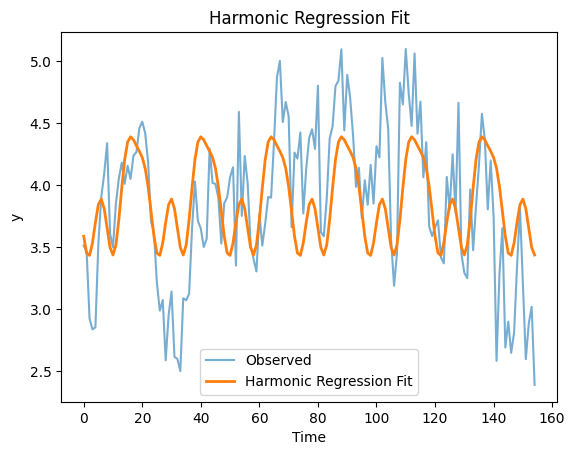

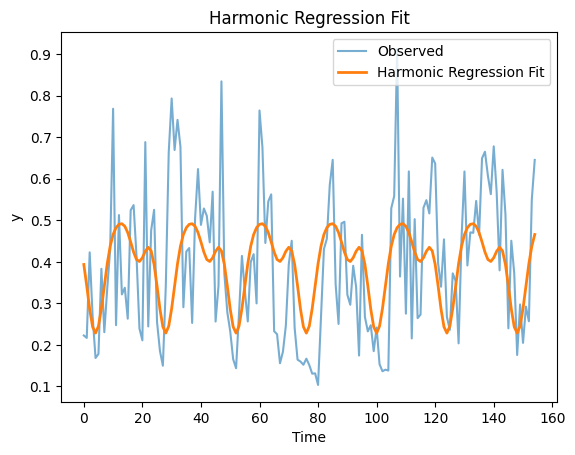

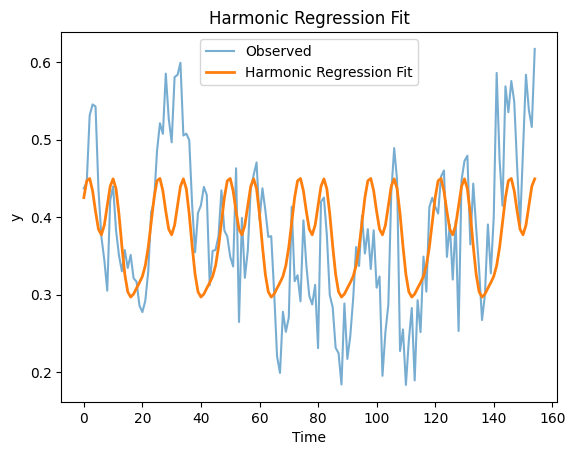

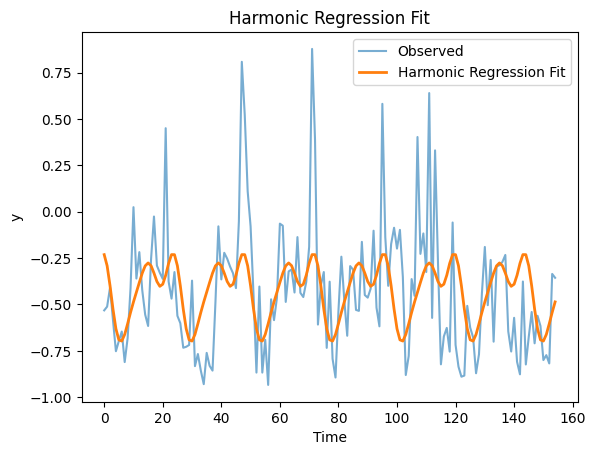

In [116]:
# Plot
for i in range(len(indices)):
    y_pred = models[i].predict(X)
    plt.plot(data["t"], data[indices[i]], label='Observed', alpha=0.6)
    plt.plot(data["t"], y_pred, label='Harmonic Regression Fit', linewidth=2)
    plt.legend()
    plt.title("Harmonic Regression Fit")
    plt.xlabel("Time")
    plt.ylabel("y")
    plt.show()